In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy.constants import R_sun

from funcs.geometry import (create_spherical_grid,
                            rotate_around_arb_axis,
                            calculate_surface_element_velocities,
                            set_up_oblique_auroral_ring,
                            )

# set dark background
plt.style.use('dark_background')


In [53]:
THETA, PHI = create_spherical_grid(int(6e4))
# input parameters

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 90 * np.pi/180

# inclination of magnetic axis in radians relative to rotation axis
i_mag = 90 * np.pi/180

# rotation period in days
P_rot = 2 * np.pi

# stellar radius in solar radii
Rstar = 1.

# upper latitude of ring around magnetic axis in radians
PHI_max = 54 * np.pi/180

# lower latitude of ring around magnetic axis in radians
PHI_min = 50 * np.pi/180

# lower latitude must be smaller than upper latitude
assert PHI_min < PHI_max

# convert dxr_visible from km/s to nm using speed of light
# and wavelength of the line
c = 299792.458 # km/s
wavelength = 3825.4 # AA Ca II H line
bins = np.linspace(-1,1,200)



In [54]:
(x, y, z), z_rot, z_rot_mag = set_up_oblique_auroral_ring(THETA, PHI, PHI_max, PHI_min, i_rot, i_mag)


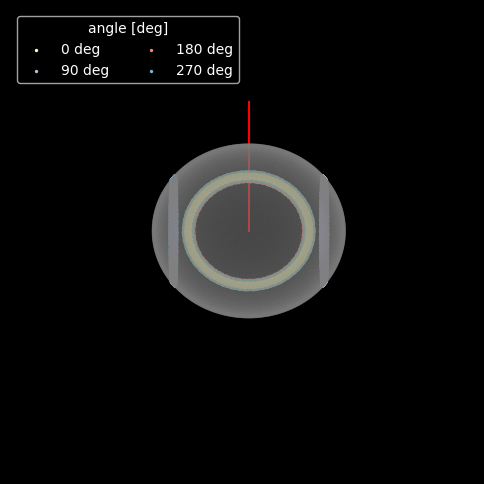

In [55]:

# plot the points on the sphere but in cartesian coordinates in 3D
fig = plt.figure(figsize=(6,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.sin(THETA)*np.cos(PHI),
              np.sin(THETA)*np.sin(PHI),
              np.cos(THETA),
                    c='grey', s=1, alpha=0.1)

ax.scatter(x, y, z, alpha=1)

# plot the x axis as a dashed line
ax.plot([-1, 1], [0, 0], [0, 0], c='w', ls='--')


# plot z_rot
ax.plot([0, 1.5 *z_rot[0]], [0, 1.5 *z_rot[1]], [0,1.5 * z_rot[2]], c='r')


# plot z_rot_mag
ax.plot([0, z_rot_mag[0]], [0, z_rot_mag[1]], [0, z_rot_mag[2]], c='b')

flux = []
angles = np.array([0, np.pi/2, np.pi, 3*np.pi/2])

# now rotate blue points around the red axis
for angle in angles:
      xr, yr, zr = rotate_around_arb_axis(angle, np.array([x, y, z]), z_rot)

      # plot the rotated blue points
      ax.scatter(xr, yr, zr, alpha=1, s=2, label=f'{angle*180/np.pi:.0f} deg')
      

      # select only the positive values of xr
      q = xr > 0

      # sum over the positive values of xr
      flux.append(np.sum(xr[q]))


# set figure limits to -1.5 to 1.5 on eacha xis
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.3, 1.2)

# label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# rotate the figure such that x-axis point towards me
ax.view_init(0, 0)

# legend
ax.legend(title='angle [deg]', loc='upper left', ncol=2)

# let axes disappear
ax.set_axis_off()

No handles with labels found to put in legend.


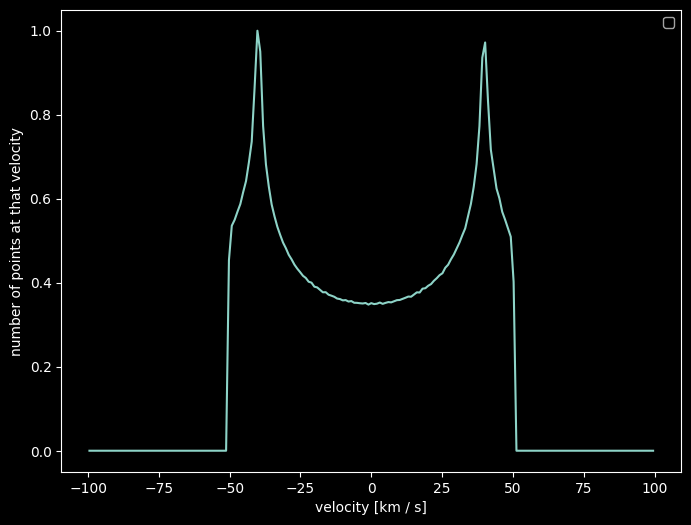

In [66]:
# angular velocity in rad/d
omega = 2 * np.pi / P_rot

# make small angle in rad
dalpha = 1 * np.pi/180

fig, ax = plt.subplots(1, 1, figsize=(8,6))

bins = np.linspace(-100,100,200)
binmids = (bins[1:] + bins[:-1])/2

alpha= 50 / 180 * np.pi

dxr_visible = []

for alpha in np.linspace(0, 360, 1000) / 180 * np.pi:

    dxr_visible.append(calculate_surface_element_velocities(alpha, dalpha, x, y, z, z_rot, omega, Rstar))

dxr_visible = np.concatenate(dxr_visible)

hist, bins = np.histogram(dxr_visible, bins=bins, density=False)

histerr = np.sqrt(hist) / np.max(hist)

hist = hist / np.max(hist)


# make a histogram of the derivative of xr
ax.plot(binmids, hist);


ax.set_xlabel('velocity [km / s]')
ax.set_ylabel('number of points at that velocity')
ax.legend()


# write binmids and hist to file as v_radial_km_s vs intensity after converting to Dataframe
df = pd.DataFrame({'v_radial_km_s': binmids, 'intensity': hist, 'intensity_err': histerr})

df.to_csv('rotating_oblique_ring_spectral_signatures.csv', index=False)


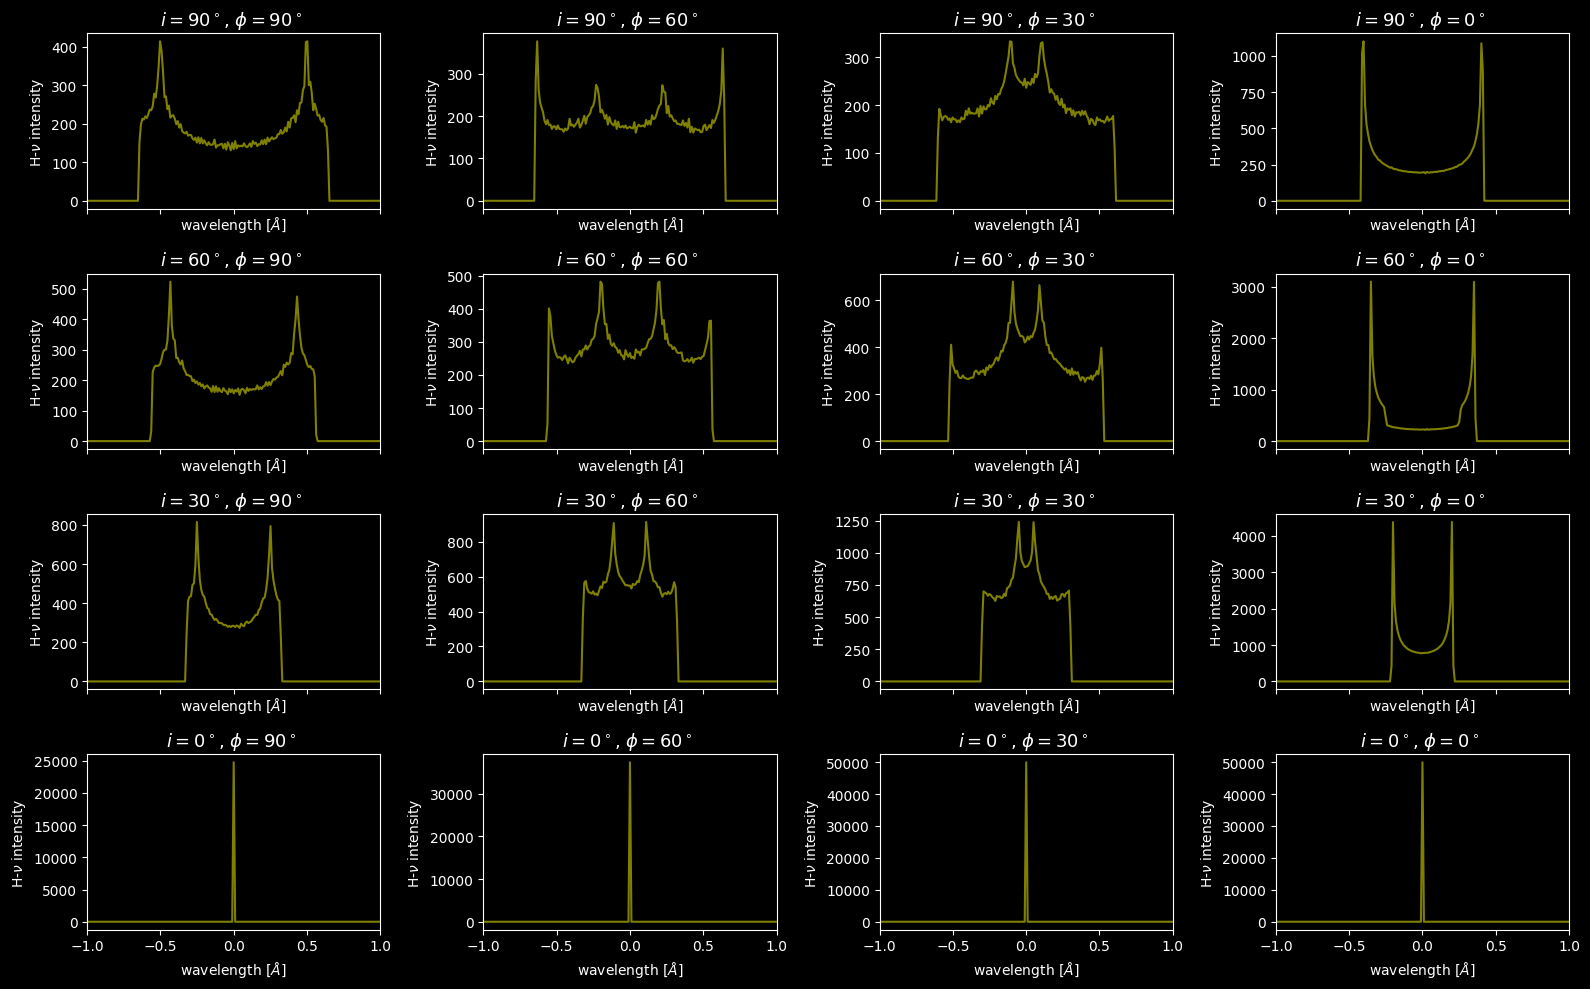

In [45]:








# plot the histogram
fig, ax = plt.subplots(4, 4, figsize=(16,10), sharex=True, sharey=False)

axes = ax.flatten()

i_rots = np.pi/2 - np.array([90, 60, 30, 0]) / 180 * np.pi
i_mags = np.array([90, 60, 30, 0]) / 180 * np.pi

# make a list of 16 tuples of (i_rot, i_mag)
i_rot_mags = [(i_rot, i_mag) for i_rot in i_rots for i_mag in i_mags]

for ax, (i_rot, i_mag) in zip(axes, i_rot_mags):

    (x, y, z), z_rot, z_rot_mag = set_up_oblique_auroral_ring(THETA, PHI, PHI_max, PHI_min, i_rot, i_mag)

    hists = []

    for alpha in np.linspace(0, 2*np.pi, 150):

        dxr_visible = calculate_surface_element_velocities(alpha, dalpha, x, y, z, z_rot, omega, Rstar)

        # convert to nm
        dxr_visible = dxr_visible * wavelength / c

        hist, bins = np.histogram(dxr_visible, bins=bins, density=False)

        hists.append(hist)

    # concatenate all histograms
    dxr_visible_ = np.sum(hists, axis=0)

    

    ax.plot((bins[1:] + bins[:-1]) / 2, dxr_visible_, alpha=0.5,
            linestyle="solid", color='yellow')


    ax.set_xlabel(r'wavelength [$\AA$]');
    ax.set_ylabel(r'H-$\nu$ intensity');
    ax.set_title(f"$i={(np.pi/2 - i_rot)/np.pi*180:.0f}^\circ$, $\phi={i_mag/np.pi*180:.0f}^\circ$ ",
             loc='center', fontsize=13)
    ax.set_xlim(-1,1)

plt.tight_layout()


### next steps

- select some model spectra of brown dwarfs
- find the locations of where Balmer lines and He I lines are
- rotationally broaden the spectrum
- insert auroral signature (maybe subtract the area from the overall flux? That should give better contrast if the emission is opaque..)


### alt next steps

- look for signatures that look the same
    - what about circles? probably not double horned shape



